Equipo 2:

Álvaro Martín López 

Daniel Pérez Martínez

# ANALIZADOR DE SENTIMIENTO (NLP con Python)

![title](resources/Images/0_Portada.jpg)

## INTRODUCCIÓN

En este informe se verá todo el proceso necesario para crear un analizador de sentimiento en Python. Este proceso comprende desde la búsqueda y exploración del conjunto de datos hasta la visualización del resultado final.

En concreto, primero veremos cómo obtener datos de entrenamiento para nuestro modelo y cómo debemos ajustarlos para un correcto funcionamiento del mismo.

Posteriormente, veremos el pre-procesamiento necesario en estos datos de cara al NLP, para lo que utilizaremos funcionalidades de las librerías _pandas_ , _spaCy_ y _sklearn_ principalmente

Una vez tengamos el conjunto de datos listo, procederemos a crear nuestro modelo y a entrenarlo con los datos obtenidos.

Por último, realizaremos una predicción para comprobar la precisión de nuestro modelo.

También se incluye un apartado con consideraciones varias

## EXPLORACIÓN DE DATOS

Nuestro modelo clasificador utiliza el paradigma del aprendizaje supervisado. Esto significa que tenemos que aportarle como entrada un conjunto de datos etiquetados. 

#### Obtención de datos

En nuestro caso, este conjunto de datos será una colección de frases con su correspondiente etiqueta indicando el sentimiento de la misma.

Para ello, nos apoyaremos en kaggle.com. Kaggle, una subsidiaria de Google LLC, es una comunidad en línea de científicos de datos y profesionales del aprendizaje de máquinas. Kaggle permite a los usuarios encontrar y publicar conjuntos de datos, explorar y construir modelos en un entorno de ciencia de datos basado en la web, trabajar con otros científicos de datos e ingenieros de aprendizaje de máquinas, y participar en competiciones para resolver los desafíos de la ciencia de datos. 

Así pues, buscaremos algún conjunto de datos que nos valga, como https://www.kaggle.com/c/spanish-arilines-tweets-sentiment-analysis/data

Este conjunto consiste en diversos tweets en español acerca de las experiencias de viajeros con distintas compañias. Como podemos ver en la preview de Kaggle, contamos con varias versiones que añaden campos extra, como si los tweets son respuestas a otros, las localizaciones de los mismo... En el caso que nos ocupa solo queremos el texto y la etiqueta:

![title](resources/Images/1_Kaggle_Preview.png)


En la imagen superior podemos ver los porcentajes de tweets de cada tipo. Como se puede observar, las negativas son  más frecuentes que las neutrales o positivas, algo que puede afectar al modelo. También podemos ver que no hay valores nulos o que falten, algo que no sería deseable tampoco. Por último, vemos que aparte de "text" y "airline_sentiment", los campos que nos sirven para el caso que nos ocupa, también contamos con otros campos extra de los que nos desharemos a continuación.

Sin embargo, no siempre se dispone de las herramientas de kaggle para poder ver estos datos pues, en muchas ocasiones, el conjunto de datos de entrada lo habremos generado nosotros mismos. Veamos cómo explorar estos datos a mano ayudandonos de la librería *pandas*

In [1]:
import pandas as pd

data = pd.read_csv('resources/tweets_public.csv')
data.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,neutral,False,0,0,Trabajar en #Ryanair como #TMA: https://t.co/r...,NaN,Fri Nov 03 12:05:12 +0000 2017,926419989107798016,NaN,Madrid
1,neutral,True,0,0,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,NaN,Sun Nov 26 18:40:28 +0000 2017,934854385577943041,NaN,Mexico City
2,negative,False,0,0,Sabiais que @Iberia te trata muy bien en santi...,NaN,Mon Dec 25 15:40:45 +0000 2017,945318406441635840,NaN,Madrid
3,negative,False,0,0,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,NaN,Mon Nov 06 14:18:35 +0000 2017,927540721296568320,NaN,Pacific Time (US & Canada)
4,positive,True,0,0,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,NaN,Mon Jan 01 23:00:57 +0000 2018,947965901332197376,NaN,Buenos Aires


Primero nos desharemos de las columnas que no nos interesan para nuestro caso y cambiaremos el nombre de una a algo más accesible

In [2]:
data = data[['airline_sentiment','text']]
data.rename(columns = {'airline_sentiment' : 'sentiment'}, inplace = True)
data.head()

,sentiment,text
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...
2,negative,Sabiais que @Iberia te trata muy bien en santi...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...


Veamos ahora si tenemos algún valor nulo o que no encaje aunque, como ya sabíamos, no los hay:

In [3]:
data.isnull()[data.isnull().eq(True).any(1)]

,sentiment,text


Ahora que tenemos el conjunto con una preparación inicial, utilizaremos herramientas que nos ofrece la librería *pandas* ,*seaborn* y *matplotpy* para visualizar gráficamente los datos.

#### Exploración de datos

Primero calcularemos la longitud de cada tweet, buscando alguna relación entre la longitud y el sentimiento asignado:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

Veremos a continuación una gráfica que muestra la distribución de la longitud de tweets, de forma que determinemos la longitud "normal" de los mismos.

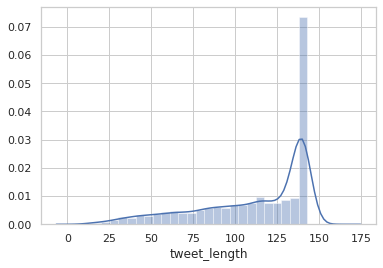

In [5]:
data['tweet_length'] = data['text'].str.len()
sns.distplot(data['tweet_length'])

De dicha gráfica podemos establecer que la longitud normal de un tweet suele estar por debajo de 150 caracteres. Es decir, la mayor parte de los tweets son opiniones directas y contundentes, sin mucho contenido. Esto implica que, a la hora del análisis, las palabras relevantes no serán abundantes.

Veremos ahora un gráfico de barras para comprobar la frecuencia de aparición de cada etiqueta.

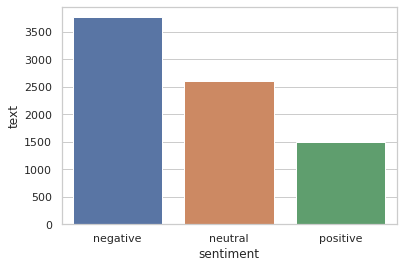

In [6]:
aux = data.groupby('sentiment').count()
sns.barplot(data = aux, x = aux.index, y = 'text')

Como la diferencia no es sumamente notoria y este informe pretende enseñar los pasos más que resultados admirables, no vamos a editar más el conjunto de datos aunque, de ser necesario, se eliminarían frases aleatorias de los tipos que correspondan para tener un conjunto más igualado. 

Es importante recalcar que esto último no siempre es necesario, pues las frecuencias de aparición de cada tipo a veces son unas mayores que otras de forma natural

Para acabar, mostraremos una gráfica que representa de forma cruzada las medidas anteriores, para buscar alguna relación entre el sentimiento y el tamaño del tweet

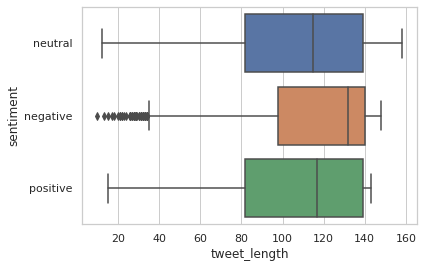

In [7]:
sns.boxplot(data=data, x='tweet_length', y='sentiment')

__NOTA__: Es necesario remarcar que la precisión del modelo se verá en su mayor parte afectada por la calidad del conjunto de datos de entrada. Sin embargo, los datasets de sentimiento públicos para textos en español son bastante escasos y de una calidad media. Se avisa que la precisión final del modelo no será muy alta debido a esto. Más información en el apartado de consideraciones

## PRE-PRECESAMIENTO DE LOS DATOS

Antes de introducir estos datos a nuestro modelo, debemos aplicarles un preprocesamiento. Estamos trabajando con lenguaje natural, el cual es vasto y variante, por lo que hay que tomar una serie de medidas para normalizar los datos. 

En nuestro caso, recorreremos nuestro conjunto transformando las frases a minúscula y cambiando las letras con tilde por las mismas sin tilde, ya que al coger los datos de tweets, debemos tener en cuenta que no todo el mundo escribe correctamente. Dejaremos solo las letras (esto es, quitar emojis, links, hashtags, puntuación..) de forma que solo queden palabras y, una vez hecho, las lematizaremos, es decir, obtendremos el lexema o raíz. Esto resulta muy útil para que tokens que la máquina podría considerar distintos a priori ( _corrió, corrimos_ ) sean considerados correctamente como un mismo token ( _correr_ ).

Por último, eliminaremos las llamadas _stopwords_ , que son palabras que suelen ser frecuentes pero no aportan nada de significado real, como pueden ser preposiciones, conjunciones...

#### Modificación de caracteres

Empecemos entonces con el paso a minúsculas:

In [8]:
data['tokens'] = data['text'].str.lower()
data.head()

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,trabajar en #ryanair como #tma: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,@iberia @fionaferrer cuando gusten en cancún s...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais que @iberia te trata muy bien en santi...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,nunca nunca nunca pidáis el café de ryanair.\n...
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,140,@cris_tortu @dakar @iberia @mitsubishi_es @bfg...


A continuación, definiremos una función que eliminará los números, signos de puntuación, "_#_", "_@_" y links. Para ello nos ayudaremos del módulo de expresiones regulares _re_

In [9]:
import re

def only_words(sentence):
    url_reg = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_reg = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_reg = re.compile('[ ]{2,}')
    
    result = url_reg.sub('', sentence)
    result = html_reg.sub('', result)
    result = spaces_reg.sub('', result)
    result = re.findall('\w+', result)
    result = [''.join(x for x in i if x.isalpha()) for i in result]
    result = ' '.join(result)
    
    return result

In [10]:
test= "Esto es una prueba hecha por @alvaro y @dani, 2 estudiantes para #TIE y aquí un link falso: https://unaweb.com/tienda"
print(only_words(test))

Esto es una prueba hecha por alvaro y dani  estudiantes para TIE y aquí un link falso


Como vemos, obtenemos un buen resultado con pocas líneas de código. Manejar con soltura expresiones regulares es algo que ayuda mucho de cara al preprocesamiento, pues nos permite obtener cómoda y exactamente las características de los datos que nos interesan.

In [11]:
data['tokens'] = data['tokens'].apply(only_words)
data.head(4)

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,trabajar en ryanair como tma empleo
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberia fionaferrer cuando gusten en cancún se ...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais que iberia te trata muy bien en santia...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,nunca nunca nunca pidáis el café de ryanair bu...


__NOTA__ : Según la intención del analizador, puede que no nos interese eliminar las menciones. Por ejemplo, si lo que queremos es obtener la opinión de distintas compañías de vuelo utilizando este dataset, nos interesa eliminar únicamente el símbolo "@" pero dejar el nombre "iberia", "ryanair"... Si nuestro analizador esta enfocado a opiniones en Twitter es una buena idea dejar los nombres de usuario y hashtags sin su respectivo símbolo. En nuestro caso da un poco igual pues lo que interesa es mostrar el proceso de creación y predicción del modelo, pero se recomienda esforzarse en esta parte del preprocesamiento que utiliza expresiones regulares, pues puede modificar los resultados notablemente.

#### Eliminación de stop words

Para la eliminación de _stopwords_ nos apoyaremos en la herramienta _spaCy_ . Esta herramienta es muy potente cuando se trata de procesar lenguaje natural. Es capaz incluso de realizar análisis semántico cuando el texto está correctamente escrito y además con una precisión asombrosa. Sin embargo, nuestros datos proceden de _tweets_ así que únicamente utilizaremos su lematizador y su lista de _stopwords_.

Una vez más, encontramos dificultades dado el idioma de nuestro texto. Sin embargo, _spaCy_ ofrece también un módulo en español, aunque no tan bueno como el inglés dada la complejidad de nuestro lenguaje. Este módulo puede ser descargado con: _(python -m spacy download es_core_news_md)_

In [12]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

#Esto lo usaremos para la lematización
nlp = spacy.load('es_core_news_md')

def remove_stop_words(sentence):
    result = ""
    if sentence != None:
        sentence = sentence.split(" ")
        result = list(
        filter(lambda l: (l not in STOP_WORDS and len(l) > 2), sentence))
        result = ' '.join(result)
    return result

In [13]:
test = "esto es un test para ver el funcionamiento de la función que elimina stopwords"
print(remove_stop_words(test))

test funcionamiento función elimina stopwords


Así pues, eliminamos las _stopwords_ de nuestro conjunto de datos para posteriormente, aplicamos la lematización.

In [14]:
data['tokens'] = data['tokens'].apply(remove_stop_words)
data.head()

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,ryanair tma
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberia fionaferrer gusten cancún viaja disfruta
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais iberia santiago chile cambia asiento m...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,pidáis café ryanair vendan bordo
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,140,cristortu dakar iberia mitsubishies bfgoodrich...


Como vemos hay algunas palabras como "sabíais" que no aportan mucho al sentimiento pero que al proceder de un _tweet_ no están correctamente escritas y nuestro algoritmo no las filtra. De nuevo se remarca la importancia de la calidad de los datos y la complejidad de entrenar un modelo en nuestro idioma, por ejemplo, por las tildes. También es importante disponer de una buena lista de _stopwords_

Aun así vemos que el proceso elimina efectivamente las palabras que menos interesan como conjunciones y preposiciones, pues tienen menos significado aún y además son bastante frecuentes.

#### Lematización

La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.

Esto es útil puesto que en nuestros conjuntos de datos encontraremos muchas palabras que significan lo mismo y, de cara a la extracción de features, nos interesa que estén representadas por una sola.

Definiremos ahora, ayudándonos de _spaCy_ una funión para obtener los lexemas de las palabras.

In [15]:
def lematize(sentence):
    doc = nlp(sentence)
    result = ""
    for token in doc:
        result += token.lemma_ + " "
    return result

In [16]:
test = "Este era un test para comprobar qué tal funciona SpacY en español con algunos plurales y algunos verbos como corrieron y volaron"
print(lematize(test))

Este ser uno test parir comprobar qué tal funcionar SpacY en español con alguno plural y alguno verbo comer correr y volar 


Aunque la lematización es muy útil en el NLP, es un proceso costoso y lento, por lo que debe considerarse su uso. Además, no siempre obtiene los resultados esperados, como se ve en el test: "test __para__ comprobar" -> "test __parir__ comprobar"

Es por esto que es importante eliminar la mayor parte de _stopwords_ antes de lematizar, aunque el proceso puede fallar igualmente

A continuación procederemos a lematizar nuestro texto, cambiar formas verbales a infinitivo, sustantivos y adjetivos a singular, etc. 

In [17]:
data['tokens'] = data['tokens'].apply(lematize)
data.head(4)

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,ryanair tma
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberio fionaferrer gustar cancún viajar disfru...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais iberio santiago chile cambiar asentir ...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,pedir café ryanair vender bordar


#### Últimos retoques del preprocesamiento

Añadiremos una función más al procesamiento, consistente en eliminar las tildes, más aún trabajando con _tweets_ que probablemente estén mal escritos. Es importante realizar este paso tras la eliminación de _stopwords_ y la lematización, pues sus librerías requieren que las palabras estén correctamente escritas.

In [18]:
def remove_accents(sentence):
    replacements = {
        "á" : "a",
        "é" : "e",
        "í" : "i",
        "ó" : "o",
        "ú" : "u",
    }
    for i,j in replacements.items():
        sentence = sentence.replace (i,j)
    return sentence

In [19]:
data['tokens'] = data['tokens'].apply(remove_accents)
data.head(4)

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,ryanair tma
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberio fionaferrer gustar cancun viajar disfru...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais iberio santiago chile cambiar asentir ...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,pedir cafe ryanair vender bordar


Por último, eliminaremos aquellas oraciones que hayan quedado vacías tras el preprocesamiento y, una vez hecho esto, podremos comenzar a crear nuestro modelo clasificador

In [20]:
data = data[data['tokens'].map(lambda d: d != "")]
data = data.reset_index()
data = data.drop(columns={'index'})
data.head()

,sentiment,text,tweet_length,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,ryanair tma
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberio fionaferrer gustar cancun viajar disfru...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais iberio santiago chile cambiar asentir ...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,pedir cafe ryanair vender bordar
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,140,cristortu dakar iberio mitsubishies bfgoodrich...


Es recomendable revisar la frecuencia de aparación de las etiquetas ya que hemos eliminado algunas entradas, simplemente para comprobar que el conjunto aún es válido y no tenemos que hacer modificaciones a mayores

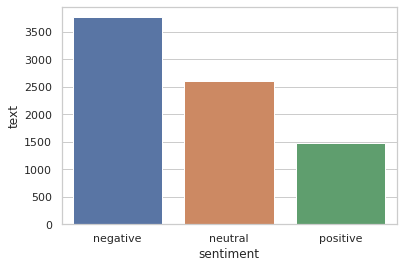

In [21]:
aux = data.groupby('sentiment').count()
sns.barplot(data = aux, x = aux.index, y = 'text')

Como vemos, si bien las frecuencias de aparición no son las más deseables, no varían mucho desde el estado inicial, por lo que nos sigue valiendo para entrenar el modelo

No se nos debe olvidar añadir un campo que codifique el sentimiento, ya que el modelo entiende de números, no de palabras.

In [22]:
codes = {
    'positive': 1,
    'neutral': 0,
    'negative' : -1
}
data['sentiment_code'] = data['sentiment']
data = data.replace({'sentiment_code' : codes})
data.head(4)

,sentiment,text,tweet_length,tokens,sentiment_code
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,63,ryanair tma,0
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,84,iberio fionaferrer gustar cancun viajar disfru...,0
2,negative,Sabiais que @Iberia te trata muy bien en santi...,140,sabiais iberio santiago chile cambiar asentir ...,-1
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,76,pedir cafe ryanair vender bordar,-1


Antes de entrenar nuestro modelo, guardaremos el conjunto de datos mediante _pickle_, un sistema de de serialización de objetos en python que almacena su contenido en un fichero binario para poder recuperarlos fácilmente y no tener que pasar por el preprocesamiento de nuevo.

In [23]:
data.to_pickle("resources/sentiment_data.pickle")

Las funciones anteriores se pueden agrupar dentro de una mayor que realice todo el preprocesamiento necesario a cada oración, pero de esta forma es más claro para explicar cada parte. Aun así, como los datos de entrada que obtendrá el modelo para predecir el sentimiento también tienen que estar tokenizados, definiremos una función que haga todo de golpe:

In [24]:
def tokenize(dataframe):
    """
    La función tendrá como entrada un dataframe con una columna "text" que contendrá el texto crudo inicial.
    Devolverá un dataframe similar pero con la columna "tokens" añadida.
    """
    data = dataframe
    
    data['tokens'] = data['text'].str.lower()
    data['tokens'] = data['tokens'].apply(only_words)
    data['tokens'] = data['tokens'].apply(remove_stop_words)
    data['tokens'] = data['tokens'].apply(lematize)
    data['tokens'] = data['tokens'].apply(remove_accents)
    
    return data

__NOTA__: Antes de continuar con la creación y entrenamiento del modelo debemos recordar que el preprocesamiento es una parte clave en el NLP y que, si bien cuanto más completo sea mejores resultados obtendremos, hay que adecuarlo a nuestras necesidades, pues puede suponer un coste en tiempo de computación bastante elevado.

## CREACIÓN Y ENTRENAMIENTO DEL MODELO

Lo primero que debemos hacer llegado este punto es dividir nuestro conjunto de datos en dos subconjuntos, uno para el entrenamiento y otro para probar el modelo. A partir de ahora utilizaremos la librería *sklearn*, que es una biblioteca para aprendizaje automático de software libre para  Python. Incluye varios algoritmos de clasificación, regresión y análisis de grupos entre los cuales están máquinas de vectores de soporte, bosques aleatorios como el que usaremos, Gradient boosting, K-means y DBSCAN.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['tokens'],
                                                    data['sentiment_code'],
                                                    test_size=0.10)

Se debe tener cuidado a la hora de elegir el tamaño de los subconjuntos para que no haya sobreentrenamiento. En nuestro caso hemos decidido que el subconjunto de prueba suponga un 10% del total, mientras que el 90% restante se empleará para entrenar el modelo.

#### Extracción de características

Ahora que tenemos las palabras relevantes (tokens) y el conjunto de datos divididos, implementaremos el modelo __TF-IDF__ (Term Frequency - Inverse Dicument Frequency). Mediante este modelo obtendremos las palabras clave con mayor frecuencia de aparición.

![title](resources/Images/2_TFIDF.jpeg)

Como se dijo anteriormente se usará la librería _sklearn_ para crear el vectorizador. Dicho vectorizador realizará el proceso de extracción de features de los datos de entrada. De esta forma se convierten las palabras en números junto a su frecuencia de aparición en cada tweet y en toda la colección 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

Procedamos ahora a la extracción de features

In [27]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

Es interesante guardar también nuestro vectorizador que ya utiliza el conjunto de datos deseado de cara a cargarlo más tarde y ahorrar el proceso de crearlo.

In [28]:
import pickle
with open('resources/tfidf.pickle', 'wb') as file_tfidf:
    pickle.dump(tfidf, file_tfidf)

También resulta interesante observarlas features que se han extraído para comprobar que el proceso seguido hasta ahora es correcto

#### Algoritmo de clasificación

Para la creación del modelo de clasificación hemos elegido, obviamente, un algoritmo de clasificación, el _RandomForestClassifier_. Este es un estimador que se ajusta a un número de clasificadores de árboles de decisión con varias submuestras de los datos. Utiliza el promedio para mejorar su precisión y el sobreentramiento del que hablamos anteriormente. El tamaño de la submuestra es siempre el mismo que el tamaño original de la muestra de entrada, aunque las muestras se extraen con reemplazo si bootstrap = True (por defecto)

![title](resources/Images/3_RFC.png)

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Validación cruzada y búsqueda de hiper-parámetros

En la celda de arriba podemos ver los parámetros de nuestro objeto clasificador. En base a ellos creamos un pequeño diccionario con los posibles valores para utilizadrlo en una validación cruzada, obteniendo así la mejor combinación de hiper-parámetros, es decir, la de la precisión más alta.

In [30]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100],
}

Para la validación cruzada utilizaremos _GridSearchCV_ , también de la librería de _sklearn_ , que utiliza los posibles hiper-parámetros que le aportamos para decidir los que mejor encajan con nuestro conjunto de datos.

In [31]:
from sklearn.model_selection import GridSearchCV

gridsearch = GridSearchCV(estimator = rfc,
                          param_grid = params,
                          cv = 2,
                          n_jobs = 1)

gridsearch.fit(features_train, labels_train)
print(gridsearch.best_params_)
print(gridsearch.cv_results_['mean_test_score'])

{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}
[0.56593717 0.5646647  0.57554807 0.56310951 0.567774   0.57554827]


Aunque lenta, si disponemos de tiempo y recursos es muy recomendable realizar una validación cruzada.

Una vez tenemos los mejores parámetros, creamos nuestro objeto _RandomForestClassifier_ definitivo y lo entrenamos con las features y etiquetas destinadas al entrenamiento.

In [41]:
rfc = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_features = 'log2', n_estimators = 100)
rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

A continuación comprobaremos la precisión del modelo utilizando las features y etiquetas destinadas al test.

In [42]:
prediction = rfc.predict(features_test)
print(rfc.score(features_test, labels_test))

0.5527318932655655


Como adelantamos al principio, dada la calidad de los datos no hemos obtenido muy buena precisión (55.27%). Una precisión aceptable para un modelo profesional debería superar el 75-80 % de precisión.

Igual que hicimos con los datos tokenizados y el vectorizador, guardaremos el modelo con el fin de cargarlo directamente para futuras predicciones y ahorrarnos todo este proceso

In [43]:
with open('resources/rfc.pickle', 'wb') as file_rfc:
    pickle.dump(rfc, file_rfc)

## PREDICCIÓN

Supongamos ahora que queremos clasificar un documento en cuanto a su sentimiento. Utilizaremos uno ya preparado con un conjunto de frases también procedentes de tweets.

In [44]:
tweets = pd.read_pickle('resources/test_tweets.pickle')
tweets.head()

,text
0,@Iberia Gracias por la respuesta: envié más de...
1,Celebrando los 90 años de @Iberia \nFelicidade...
2,Iberia Express lanza una promoción de 5.000 bi...
3,"Con @Iberia, mi destino a un solo click. ¡Dese..."
4,@Iberia Muy bien. Muchas gracias


En primer lugar, si los datos no están tokenizados, debemos tokenizarlos, es por donde debemos empezar. Aprovecharemos ahora la función que creamos anteriormente:

In [45]:
tweets = tokenize(tweets)
tweets.head()

,text,tokens
0,@Iberia Gracias por la respuesta: envié más de...,iberio gracia respuesta enviar detallar adjunt...
1,Celebrando los 90 años de @Iberia \nFelicidade...,celebrar año iberio felicidad llevar año forma...
2,Iberia Express lanza una promoción de 5.000 bi...,iberio express lanzar promocion billete eurosv...
3,"Con @Iberia, mi destino a un solo click. ¡Dese...",iberio destinar click deseadme suerte holaarge...
4,@Iberia Muy bien. Muchas gracias,iberio gracia


A continuación, cargamos nuestro vectorizador para extraer las features del documento.

In [46]:
import pickle

with open('resources/tfidf.pickle', 'rb') as f:
    tfidf = pickle.load(f)
    
features = tfidf.transform(tweets['text']).toarray()

Cargamos ahora nuestro clasificador y realizamos la predicción.

In [47]:
with open('resources/rfc.pickle', 'rb') as f:
    rfc = pickle.load(f)
    
prediction = rfc.predict(features)

Esta predicción aún está en números, por lo que debemos crear una función que la traduzca a un lenguaje que pueda entender un humano.

In [48]:
def human_prediction(prediction):

    pos = 0
    neu = 0
    neg = 0

    for p in prediction:
        if p == -1:
            neg += 1
        elif p == 0:
            neu += 1
        elif p == 1:
            pos += 1

    pos_percentage = pos/len(prediction) 
    neu_percentage = neu/len(prediction)
    neg_percentage = neg/len(prediction)

    return {'pos':pos_percentage, 'neu':neu_percentage, 'neg': neg_percentage}

In [49]:
print(human_prediction(prediction))

{'pos': 0.0, 'neu': 0.3333333333333333, 'neg': 0.6666666666666666}


Dicha predicción no tiene mucha precisión, como vimos anteriormente, pues en el documento de prueba había un tercio de cada tipo. Además, vemos que tiene tendencia a decidir que las frases son de tipo "negativo", algo que se puede esperar dado que gran parte del conjunto de entrenamiento estaba etiquetado de dicha forma, como se vio en la exploración de datos inicial. De aquí la importancia de hacer una exploración previa de los datos antes de preprocesarlos.

## CONSIDERACIONES

Hemos aprendido en este informe los pasos básicos del proceso de crear un modelo clasificador, los cuales son:

· Obtención y exploración de datos

· Preprocesamiento de los mismos

· Creación y entrenamiento del modelo

· Predicción


Es necesario remarcar una vez más la importancia del conjunto de datos de entrada, pues, como se ha visto, una vez se han preprocesado estos, el proceso no tiene excesiva ciencia. Un conjunto de datos amplio y de calidad mejorará notablemente la precisión de nuestro modelo, aunque por desgracia no hemos tenido acceso a algo así. 

A esto tenemos que sumarle que el preprocesamiento no es un paso que se lleve a cabo siempre igual, sino que debe ser adecuado a la finalidad de cada modelo. Nosotros hemos hecho un preprocesamiento generalizado con algunas de las funcionalidades que más se suelen ver pero repetimos que es importante adecuarlo a la finalidad del modelo y a los datos de entrada, pues el estado en el que estén los datos con los que se entrene el modelo influirá determinantemente en su precisión.

Una de las funcionalidades extra que se proponen son el manejo de negaciones, aunque no se ha mostrado dada su complejidad. Esto hace referencia a que la frase "No me gustan las lentejas", una vez que es preprocesada, podría seguramente perder el "no" del principio, cambiando completamente su significado. 

También hay que tener cuidado en el preprocesamiento con el orden en el que se tokenizan las frases. No es lo mismo lematizar y luego eliminar las _stopwords_ que al revés. En algunas ocasiones puede que ni si quiera querramos lematizar.

Por último, considerar que hay unos cuantos algoritmos más que solucionarían nuestro problema, clasificar por sentimiento documentos. Sin embargo, no hay una receta general para saber cuál de ellos usar. Lo suyo es informarse de las ventajas y desventajas de cada uno y realizar varios modelos con los mismos datos de prueba para determinar cuál obtiene una precisión mayor adecuandose a nuestra necesidad. Aun así, en este informe se ha decidido mostrar solo una forma, ya que si no el trabajo se extendería mucho.

## Referencias

Kaggle - https://www.kaggle.com/

Spanish Airlines Tweets Sentiment Analyis - https://www.kaggle.com/c/spanish-arilines-tweets-sentiment-analysis/data

Seaborn - https://seaborn.pydata.org/

Matplotlib - https://matplotlib.org/

Pandas - https://pandas.pydata.org/

Regex - https://docs.python.org/3/library/re.html

SpaCy - https://spacy.io/

SpaCY español - https://spacy.io/models/es

Sklearn - https://scikit-learn.org/stable/

TF-IDF - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

RandomForestClassifer - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

GridSearchCV - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html